In [1]:
from IPython.display import clear_output

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [3]:
%load_ext pycodestyle_magic

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from itertools import chain
from tqdm.notebook import tqdm
from warnings import filterwarnings
from datetime import datetime, timedelta

%matplotlib inline

In [5]:
filterwarnings('ignore')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
!wget https://www.manythings.org/anki/rus-eng.zip

--2021-02-11 02:48:38--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14042100 (13M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13.39M  18.9MB/s    in 0.7s    

2021-02-11 02:48:39 (18.9 MB/s) - ‘rus-eng.zip’ saved [14042100/14042100]



In [8]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [9]:
!rm rus-eng.zip _about.txt

In [10]:
df = pd.read_csv('rus.txt', sep='\t', header=None).drop(2, axis=1)

In [11]:
df.head(15)

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
5,Hi.,Хай.
6,Hi.,Здрасте.
7,Hi.,Здоро́во!
8,Run!,Беги!
9,Run!,Бегите!


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421765 entries, 0 to 421764
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       421765 non-null  object
 1   1       421765 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [13]:
df[0] = df[0].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[1] = df[1].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[0] = df[0].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))
df[1] = df[1].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))

In [14]:
df.sample(n=15)

,0,1
277017,you re in no condition to drive,ты не в том состоянии чтобы вести машину
381447,i d like to hear a lot more about your trip,я хотел бы послушать побольше о вашем путешествии
254931,the cat was basking in the sun,кот нежился на солнце
202004,it rained heavily yesterday,вчера шёл сильный дождь
99889,i ve seen you do that,я видел как ты это делал
407670,what you have just said reminds me of an old s...,то что вы только что сказали напоминает мне ст...
318674,i found the problem was easy to fix,я нашёл что проблему было легко решить
394164,if i had enough money i could buy this camera,будь у меня достаточно денег я бы смог купить ...
591,i got it,понял
295389,i still cry when i think about it,я до сих пор плачу когда думаю об этом


In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [16]:
pairs = list(zip(df[0].tolist(), df[1].tolist()))

In [17]:
del df

In [18]:
pairs = filterPairs(pairs)

In [19]:
len(pairs)

27003

In [20]:
eng_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[0].split() for pair in pairs])))
    )

In [21]:
len(eng_dict)

4271

In [22]:
eng_dict[:10]

['SOS',
 'EOS',
 'a',
 'abandon',
 'ability',
 'able',
 'aboard',
 'about',
 'above',
 'abroad']

In [23]:
rus_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[1].split() for pair in pairs])))
    )

In [24]:
len(rus_dict)

10180

In [25]:
rus_dict[:10]

['SOS',
 'EOS',
 'android',
 'linux',
 'windows',
 'а',
 'абсолютно',
 'абсолютной',
 'авантюрен',
 'авантюризма']

In [26]:
eng_to_idx = {elem: i for i, elem in enumerate(eng_dict)}
rus_to_idx = {elem: i for i, elem in enumerate(rus_dict)}

In [27]:
def tensors_from_pair(pair):
    eng_idx = [0] + [eng_to_idx[word] for word in pair[0].split()]
    eng_idx += [1] * (MAX_LENGTH + 1 - len(pair[0].split()))
    rus_idx = [0] + [rus_to_idx[word] for word in pair[1].split()]
    rus_idx += [1] * (MAX_LENGTH + 1 - len(pair[1].split()))
    eng_tensor = torch.tensor(eng_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    rus_tensor = torch.tensor(rus_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    return (eng_tensor, rus_tensor)

In [28]:
pair = pairs[np.random.randint(27003)]
print(pair)
print(tensors_from_pair(pair))

('i m not strong enough to do that', 'я недостаточно силён чтобы сделать это')
(tensor([[   0],
        [1868],
        [2242],
        [2511],
        [3592],
        [1233],
        [3851],
        [1081],
        [3782],
        [   1],
        [   1],
        [   1]], device='cuda:0'), tensor([[    0],
        [10135],
        [ 4435],
        [ 7966],
        [ 9920],
        [ 7851],
        [10114],
        [    1],
        [    1],
        [    1],
        [    1],
        [    1]], device='cuda:0'))


# Encoder

In [29]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder (на скалярном произведении)

In [30]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length + 2

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.div(torch.matmul(hidden[0][0], encoder_outputs[i]),
                          torch.sqrt(
                              torch.tensor(self.max_length, dtype=torch.float,
                                           device=device))
                          )
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Функции для обучения и оценки качества

In [31]:
teacher_forcing_ratio = 0.5

In [32]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, max_len=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                  device=device)
    loss = 0

    for i in range(input_tensor.size(0)):
        encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                 encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]], device=device)
    decoder_hidden = encoder_hidden

    if np.random.random() < teacher_forcing_ratio:
        use_teacher_forcing = True
    else:
        use_teacher_forcing = False

    for i in range(target_tensor.size(0)):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
            )
        loss += criterion(decoder_output, target_tensor[i])
        if use_teacher_forcing:
            # teacher forcing: feed the target as the next input
            decoder_input = target_tensor[i]
        else:
            # use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == 1:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_tensor.size(0)

In [33]:
def train_epochs(encoder, decoder, n_epochs=75000, learning_rate=0.01):
    start = datetime.now()
    plot_losses = []
    print_loss = 0 # reset every 5000 epochs
    plot_loss = 0 # reset every 100 epochs
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(pairs[np.random.randint(27003)])
                      for epoch in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(n_epochs)):
        training_pair = training_pairs[epoch]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss += loss
        plot_loss += loss

        if (epoch + 1) % 5000 == 0:
            print_loss /= 5000
            delta = datetime.now() - start
            stats = f'''
            Epoch {epoch + 1} ({(epoch + 1) * 100 / n_epochs:.1f}%)
            Time: {delta.seconds // 60}m {delta.seconds % 60}s
            Loss: {print_loss:.4f}
            '''
            print(stats)
            print_loss = 0

        if (epoch + 1) % 100 == 0:
            plot_loss /= 100
            plot_losses.append(plot_loss)
            plot_loss = 0
    return plot_losses

In [34]:
def show_losses(losses):
    plt.figure(figsize=(14, 12))
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(losses)
    plt.show()

In [35]:
def evaluate(encoder, decoder, sent, max_len=MAX_LENGTH):
    with torch.no_grad():
        idx = [0] + [eng_to_idx[word] for word in sent.split()]
        idx += [1] * (max_len + 1 - len(sent.split()))
        input_tensor = torch.tensor(idx, dtype=torch.long,
                                    device=device).view(-1, 1)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                      device=device)

        for i in range(input_tensor.size()[0]):
            encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                     encoder_hidden)
            encoder_outputs[i] = encoder_output[0, 0]

        decoder_input = torch.tensor([[0]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_len + 2, max_len + 2)

        for i in range(max_len + 2):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1:
                break
            decoded_words.append(rus_dict[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions

In [36]:
def evaluate_random(encoder, decoder, n=10):
    for i in range(n):
        pair = pairs[np.random.randint(27003)]
        pred = " ".join(evaluate(encoder, decoder, pair[0])[0][1:])
        res = f'''
        Eng:  {pair[0]}
        Rus:  {pair[1]}
        Pred: {pred}
        '''
        print(res)

# Обучение и оценка качества

In [37]:
hidden_size = 256

In [38]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [39]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [40]:
losses = train_epochs(encoder, attn_decoder)


            Epoch 5000 (6.7%)
            Time: 3m 6s
            Loss: 1.9827
            

            Epoch 10000 (13.3%)
            Time: 6m 11s
            Loss: 1.7675
            

            Epoch 15000 (20.0%)
            Time: 9m 15s
            Loss: 1.6320
            

            Epoch 20000 (26.7%)
            Time: 12m 19s
            Loss: 1.5255
            

            Epoch 25000 (33.3%)
            Time: 15m 24s
            Loss: 1.4124
            

            Epoch 30000 (40.0%)
            Time: 18m 30s
            Loss: 1.3557
            

            Epoch 35000 (46.7%)
            Time: 21m 33s
            Loss: 1.2804
            

            Epoch 40000 (53.3%)
            Time: 24m 40s
            Loss: 1.2230
            

            Epoch 45000 (60.0%)
            Time: 27m 44s
            Loss: 1.1680
            

            Epoch 50000 (66.7%)
            Time: 30m 47s
            Loss: 1.1106
            

            Epoch 55000 (73.3%)
   

<Figure size 1008x864 with 0 Axes>

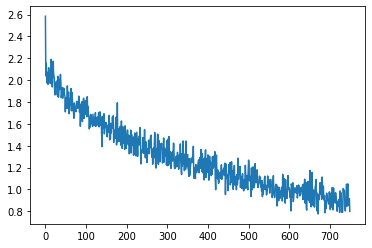

In [41]:
show_losses(losses)

Лосс стабильно падает, финальный лосс – 0.8961 (намного лучше, чем когда я просто воспроизводила лекционный ноутбук!). Посмотрим на генерацию предложений.

In [47]:
evaluate_random(encoder, attn_decoder)


        Eng:  he is two inches taller than i am
        Rus:  он меня на два дюйма выше
        Pred: он на два года на два
        

        Eng:  you re ugly
        Rus:  вы некрасивая
        Pred: ты ужасен
        

        Eng:  she says that she loves flowers
        Rus:  она говорит что очень любит цветы
        Pred: она говорит что что ей
        

        Eng:  i m worried
        Rus:  я волнуюсь
        Pred: я беспокоюсь
        

        Eng:  i m feeling so much better
        Rus:  я чувствую себя намного лучше
        Pred: мне гораздо лучше
        

        Eng:  i m sure he s alive
        Rus:  я уверен что он жив
        Pred: я уверен что он жив
        

        Eng:  i m going to go right away
        Rus:  я собираюсь идти немедленно
        Pred: я собираюсь туда в
        

        Eng:  i m not sure what tom wants
        Rus:  я не уверен в том чего том хочет
        Pred: я точно не знаю том хочет
        

        Eng:  she is a member of this organi

Одно случайное предложение переведено полностью правильно, и 4 – правильно по смыслу (если учесть, что в английском нет родов и разграничения на "ты" и "вы")!

In [58]:
pair = pairs[np.random.randint(27003)]
print(pair)

('they re average students', 'они студентысередняки')


In [59]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [60]:
attentions

tensor([[1.8234e-22, 2.2971e-18, 2.5140e-18, 1.4263e-15, 2.3459e-13, 1.8222e-07,
         8.0125e-05, 3.2233e-03, 5.0830e-02, 1.8617e-01, 3.2880e-01, 4.3089e-01],
        [1.2974e-14, 1.6351e-11, 2.1416e-11, 6.6819e-10, 1.6552e-08, 7.9446e-05,
         2.1529e-03, 1.7171e-02, 9.7870e-02, 2.1478e-01, 3.0454e-01, 3.6340e-01],
        [1.2613e-09, 1.0382e-06, 1.7512e-06, 7.3758e-06, 2.0380e-04, 7.3333e-03,
         1.5688e-02, 4.2632e-02, 1.4480e-01, 2.3309e-01, 2.7156e-01, 2.8468e-01],
        [1.0715e-05, 9.4558e-04, 9.0834e-04, 1.3227e-04, 8.6844e-04, 9.3345e-03,
         3.0432e-02, 6.8276e-02, 1.6646e-01, 2.2533e-01, 2.4465e-01, 2.5265e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0

In [63]:
attentions.numpy()[0]

array([1.8234430e-22, 2.2970562e-18, 2.5140416e-18, 1.4263311e-15,
       2.3459490e-13, 1.8221705e-07, 8.0124904e-05, 3.2232946e-03,
       5.0830420e-02, 1.8617480e-01, 3.2879877e-01, 4.3089241e-01],
      dtype=float32)

<Figure size 1008x864 with 0 Axes>

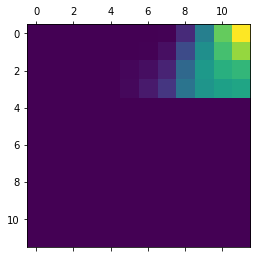

In [61]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

In [37]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words + ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [38]:
def evaluate_show_attention(sent):
    output_words, attentions = evaluate(
        encoder, attn_decoder, sent)
    print('input =', sent)
    print('output =', ' '.join(output_words[1:]))
    showAttention(sent, output_words[1:], attentions)

input = you re going to like working for me
output = вы всё что я


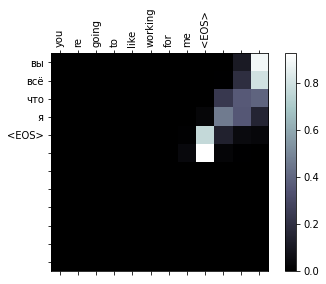

In [53]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m in the toilet
output = я в тюрьме


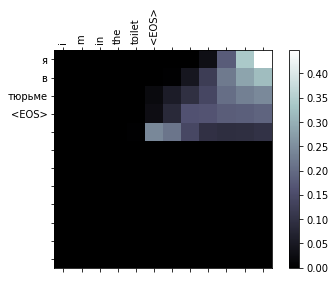

In [54]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = we re surprised
output = мы удивлены


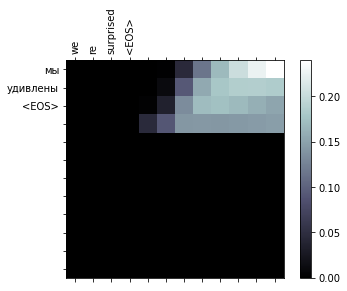

In [55]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = we re keeping an eye on them
output = мы за за


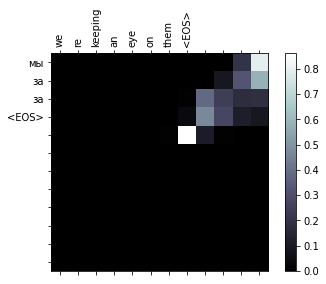

In [56]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

Очень много attention у токенов EOS, добавленных для паддинга предложений до одинаковой длины. Из-за этого на графиках attention у слов предложения не видно. Но оно есть!

# Attention Decoder (на MLP)

In [39]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.tanh(self.attn(torch.cat((hidden[0][0],
                                                encoder_outputs[i]))))
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Обучение и оценка качества

In [40]:
hidden_size = 256

In [41]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [42]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [43]:
losses = train_epochs(encoder, attn_decoder)


            Epoch 5000 (6.7%)
            Time: 3m 25s
            Loss: 2.0115
            

            Epoch 10000 (13.3%)
            Time: 6m 50s
            Loss: 1.8138
            

            Epoch 15000 (20.0%)
            Time: 10m 14s
            Loss: 1.6954
            

            Epoch 20000 (26.7%)
            Time: 13m 41s
            Loss: 1.5596
            

            Epoch 25000 (33.3%)
            Time: 17m 8s
            Loss: 1.4923
            

            Epoch 30000 (40.0%)
            Time: 20m 37s
            Loss: 1.3954
            

            Epoch 35000 (46.7%)
            Time: 24m 7s
            Loss: 1.3008
            

            Epoch 40000 (53.3%)
            Time: 27m 37s
            Loss: 1.2602
            

            Epoch 45000 (60.0%)
            Time: 31m 5s
            Loss: 1.1944
            

            Epoch 50000 (66.7%)
            Time: 34m 34s
            Loss: 1.1561
            

            Epoch 55000 (73.3%)
    

<Figure size 1008x864 with 0 Axes>

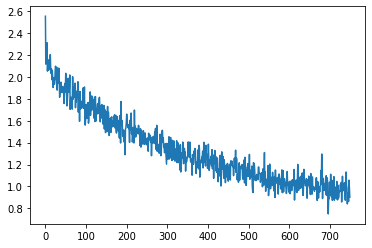

In [44]:
show_losses(losses)

Обучается чуть-чуть дольше, чем seq2seq с attention на скалярном произведении (50 минут 28 секунд против 46 минут 22 секунд), финальный loss хуже, чем у сети с attention на скалярном произведении (0.9651 против 0.8961). Посмотрим на генерацию предложений.

In [45]:
evaluate_random(encoder, attn_decoder)


        Eng:  i m living my dream
        Rus:  я живу своей мечтой
        Pred: я живу свой свою
        

        Eng:  i m the only one who understands tom
        Rus:  я единственный кто понимает тома
        Pred: я том кто тома
        

        Eng:  i m going there alone
        Rus:  я еду туда одна
        Pred: я туда туда один
        

        Eng:  you re not the only canadian here
        Rus:  вы тут не единственные канадцы
        Pred: ты здесь не единственный канадка
        

        Eng:  i m not hungry anymore
        Rus:  я уже не голодна
        Pred: я больше не не
        

        Eng:  you re very perceptive
        Rus:  вы очень проницательны
        Pred: ты очень
        

        Eng:  we re all related
        Rus:  мы все родственники
        Pred: мы все богаты
        

        Eng:  we re just pretending
        Rus:  мы понарошку
        Pred: мы просто
        

        Eng:  i am not acquainted with him
        Rus:  я не знаком с ним
      

Предсказания тоже хуже, среди всех сгенерированных предложений только одно соответствует грамматике русского языка и ни одно не переведено правильно (в точности или по смыслу).

In [46]:
pair = pairs[np.random.randint(27003)]
print(pair)

('she s beautiful isn t she', 'красивая правда')


In [47]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [48]:
attentions

tensor([[0.0634, 0.0706, 0.0767, 0.0953, 0.0738, 0.0984, 0.0747, 0.0794, 0.0921,
         0.0924, 0.0920, 0.0913],
        [0.0636, 0.0706, 0.0767, 0.0953, 0.0738, 0.0984, 0.0747, 0.0793, 0.0921,
         0.0924, 0.0919, 0.0913],
        [0.0635, 0.0710, 0.0772, 0.0947, 0.0743, 0.0975, 0.0752, 0.0798, 0.0919,
         0.0921, 0.0917, 0.0911],
        [0.0666, 0.0735, 0.0789, 0.0922, 0.0764, 0.0941, 0.0772, 0.0810, 0.0902,
         0.0903, 0.0901, 0.0896],
        [0.0648, 0.0712, 0.0768, 0.0948, 0.0741, 0.0980, 0.0750, 0.0793, 0.0917,
         0.0919, 0.0915, 0.0909],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [49]:
attentions.numpy()[0]

array([0.06341993, 0.07055162, 0.07669213, 0.09527341, 0.07377636,
       0.09841596, 0.07470179, 0.07936986, 0.09213814, 0.09239578,
       0.09195073, 0.09131426], dtype=float32)

<Figure size 1008x864 with 0 Axes>

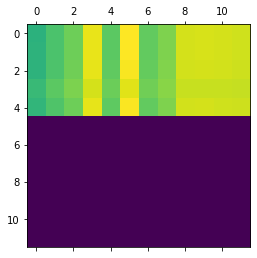

In [50]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

input = you re wrong about tom
output = вы не том


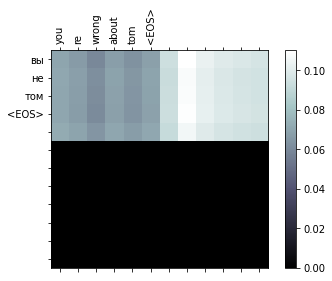

In [51]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m decisive
output = я заинтересован


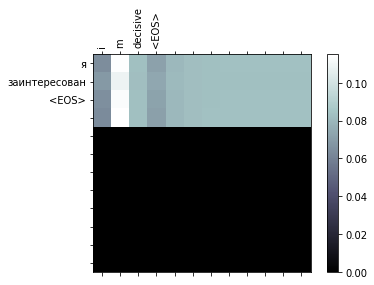

In [52]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = they are both good students
output = она хорошо хорошие


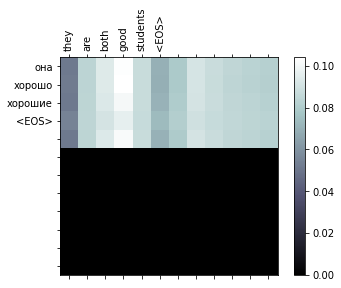

In [53]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = they re drunk
output = они пьян


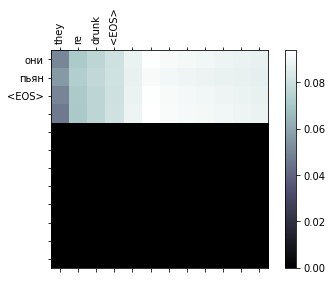

In [54]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

Зато графики attention уже больше похожи на правду – больше всего attention всё ещё у токенов EOS, добавленных в английское предложение для паддинга, но заметно, что:
*   с какого-то токена EOS attention начинает плавно уменьшаться
*   для предсказанного предложения attention ненулевое строго до токена EOS и ещё одну клетку
*   первое слово в английском предложении, как правило, обладает наименьшим attention
*   иногда и для английского, и для предсказанного предложения можно выделить "самое важное" слово – слово с наибольшим attention ("m" во втором примере, "good" в третьем)
*   а иногда слова с наибольшим attention в английском и предсказанном предложении даже совпадают ("drunk" и "пьян" в последнем примере)!